# Import Required Libraries

Install and import all the relevant libraries for the research.

In [23]:
!pip install shap

In [86]:
from google.colab import drive
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings('ignore')

import pickle

# Load the Dataset

The dataset is zipped and stored on the google drive for faster access.

In [25]:
# Mount G-Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Extract dataset from the zip file
with zipfile.ZipFile('/content/drive/MyDrive/efd_1.csv.zip', 'r') as zip_ref:
    with zip_ref.open('efd_1.csv') as file:
        df = pd.read_csv(file)

In [27]:
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [28]:
df.shape

(9841, 51)

# EDA

## Feature Info

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

This research won't use any categorial feature for modelling.

## Check for uniques values in features

In [30]:
for col in df:print(f'{col} : {len(df[col].unique())}')

Unnamed: 0 : 9841
Index : 4729
Address : 9816
FLAG : 2
Avg min between sent tnx : 5013
Avg min between received tnx : 6223
Time Diff between first and last (Mins) : 7810
Sent tnx : 641
Received Tnx : 727
Number of Created Contracts : 20
Unique Received From Addresses : 256
Unique Sent To Addresses : 258
min value received : 4589
max value received  : 6302
avg val received : 6767
min val sent : 4719
max val sent : 6647
avg val sent : 5854
min value sent to contract : 3
max val sent to contract : 4
avg value sent to contract : 4
total transactions (including tnx to create contract : 897
total Ether sent : 5868
total ether received : 6728
total ether sent contracts : 4
total ether balance : 5717
 Total ERC20 tnxs : 301
 ERC20 total Ether received : 3461
 ERC20 total ether sent : 1416
 ERC20 total Ether sent contract : 30
 ERC20 uniq sent addr : 108
 ERC20 uniq rec addr : 148
 ERC20 uniq sent addr.1 : 5
 ERC20 uniq rec contract addr : 124
 ERC20 avg time between sent tnx : 2
 ERC20 avg tim

Many features have just 2-3 values which won't contribute much to the model. We'll simply remove it later.

## Dataset Imbalance check

In [31]:
df['FLAG'].value_counts()

,count
FLAG,
0,7662
1,2179


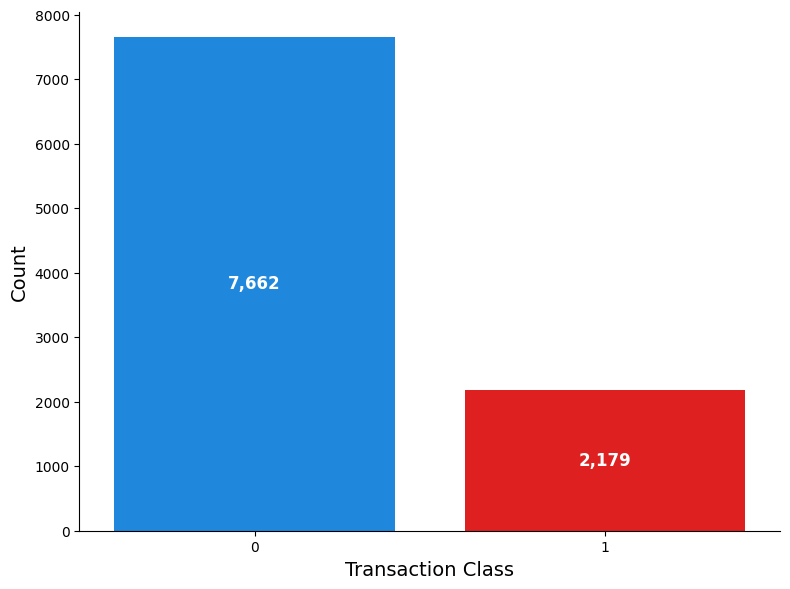

In [32]:
class_counts = df['FLAG'].value_counts()

colors = {
    'non_fraud': '#008BFB',  # Blue (non-fraud transactions)
    'fraud': '#FF0000'       # Red (fraud transactions)
}

# Plotting the bar chart
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=class_counts.index,
                      y=class_counts.values,
                      palette=[colors['non_fraud'], colors['fraud']],
                      )

# Adding annotations inside the bars
for i, value in enumerate(class_counts.values):
    barplot.text(i, value / 2, f'{value:,}', ha='center', va='center', color='white', fontsize=12, weight='bold')

# Adding labels & style to the chart
plt.xlabel('Transaction Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
sns.despine()
plt.tight_layout()

# Show the plot
plt.show()

Our dataset is highly imbalanced and we'll initially use ISMOTE for this and a novel technique later.

## Visualize missing values

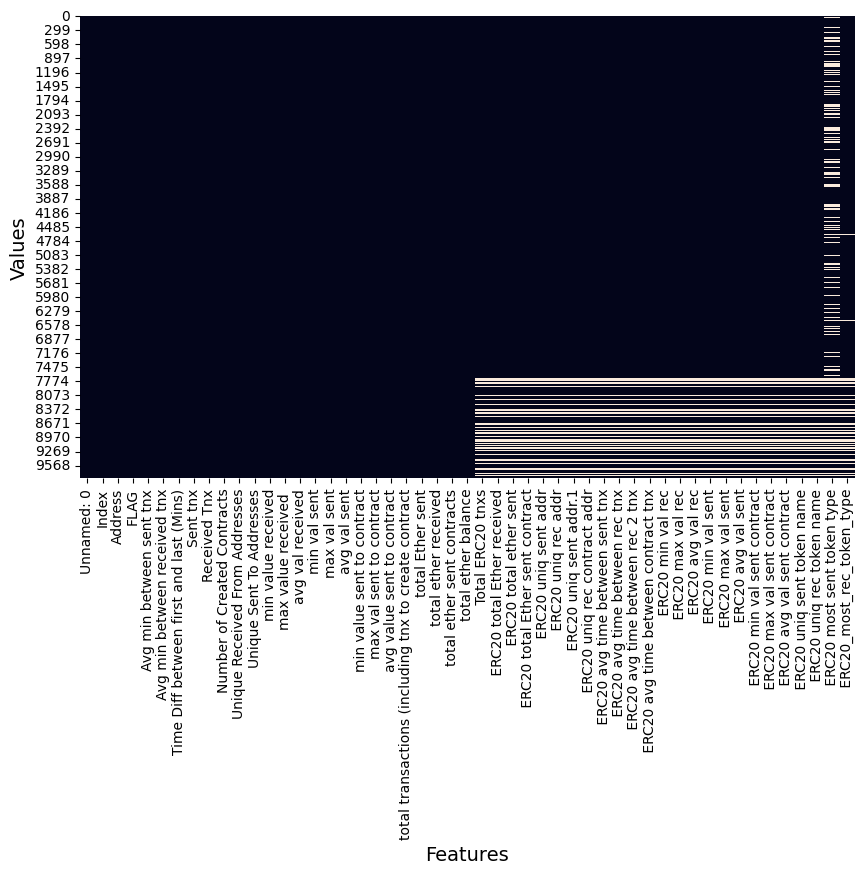

In [33]:
plt.figure(figsize=(10,6))

sns.heatmap(df.isnull(),
            cbar=False,      # Hide the color bar
            annot=False,     # No annotations inside the cells
            vmin=0,          # Set min value for color mapping
            vmax=1,
            )

# Add labels
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Show the plot
plt.show()

Features with a lot of missing values would be removed and the rest would be replaced with their median.

# Data Cleaning

## Remove unnecessary columns

***Unnamed: 0*** and ***Index*** are redundant, let's simply remove it.

In [34]:
df.drop(["Unnamed: 0", "Index"], axis=1, inplace=True)
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


## Drop Categorical features.

In [35]:
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,Address,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,StatusNetwork,EOS
...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,,GSENetwork
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,,Blockwell say NOTSAFU
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,,Free BOB Tokens - BobsRepair.com
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,NaN,NaN


Drop these categorical values

In [36]:
df.drop(df[categories], axis=1, inplace=True)

## Remove 0 features

The features with less distinct values won't help this research in building a model which detects fraud in a transaction. Hence, features with less than 5 distinct values would be identified and removed.

In [37]:
zero_feature_column = []
for i in df.columns[1:]:
    if len(df[i].value_counts()) <= 5:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')
        zero_feature_column.append(i)

print(f'Zero Feature Columns: \n{zero_feature_column}')

The column min value sent to contract has the following distribution: 
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64
The column max val sent to contract has the following distribution: 
max val sent to contract
0.000000    9838
0.020000       1
0.010000       1
0.046029       1
Name: count, dtype: int64
The column avg value sent to contract has the following distribution: 
avg value sent to contract
0.000000    9838
0.020000       1
0.010000       1
0.023014       1
Name: count, dtype: int64
The column total ether sent contracts has the following distribution: 
total ether sent contracts
0.000000    9838
0.020000       1
0.010000       1
0.046029       1
Name: count, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
 ERC20 uniq sent addr.1
0.0    8984
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64
The column  ERC20 avg time between sent tnx has the following distribution: 
 ERC20 avg time betwee

In [38]:
df.drop(zero_feature_column, axis=1, inplace=True)
print(df.shape)

(9841, 34)


## Handling null values

As discussed, features with null values would be removed or replaced with their median values.

In [39]:
df.isnull().sum()

,0
FLAG,0
Avg min between sent tnx,0
Avg min between received tnx,0
Time Diff between first and last (Mins),0
Sent tnx,0
Received Tnx,0
Number of Created Contracts,0
Unique Received From Addresses,0
Unique Sent To Addresses,0
min value received,0


As all the features with missing values are important for this research, we'll simply replace those numerical null values with the feature median.

In [40]:
df.fillna(df.median(), inplace=True)

In [41]:
df.isnull().sum()

,0
FLAG,0
Avg min between sent tnx,0
Avg min between received tnx,0
Time Diff between first and last (Mins),0
Sent tnx,0
Received Tnx,0
Number of Created Contracts,0
Unique Received From Addresses,0
Unique Sent To Addresses,0
min value received,0


## Handling Correlation in features.

As the basic cleaning is performed, it's time to find correlation in the features.

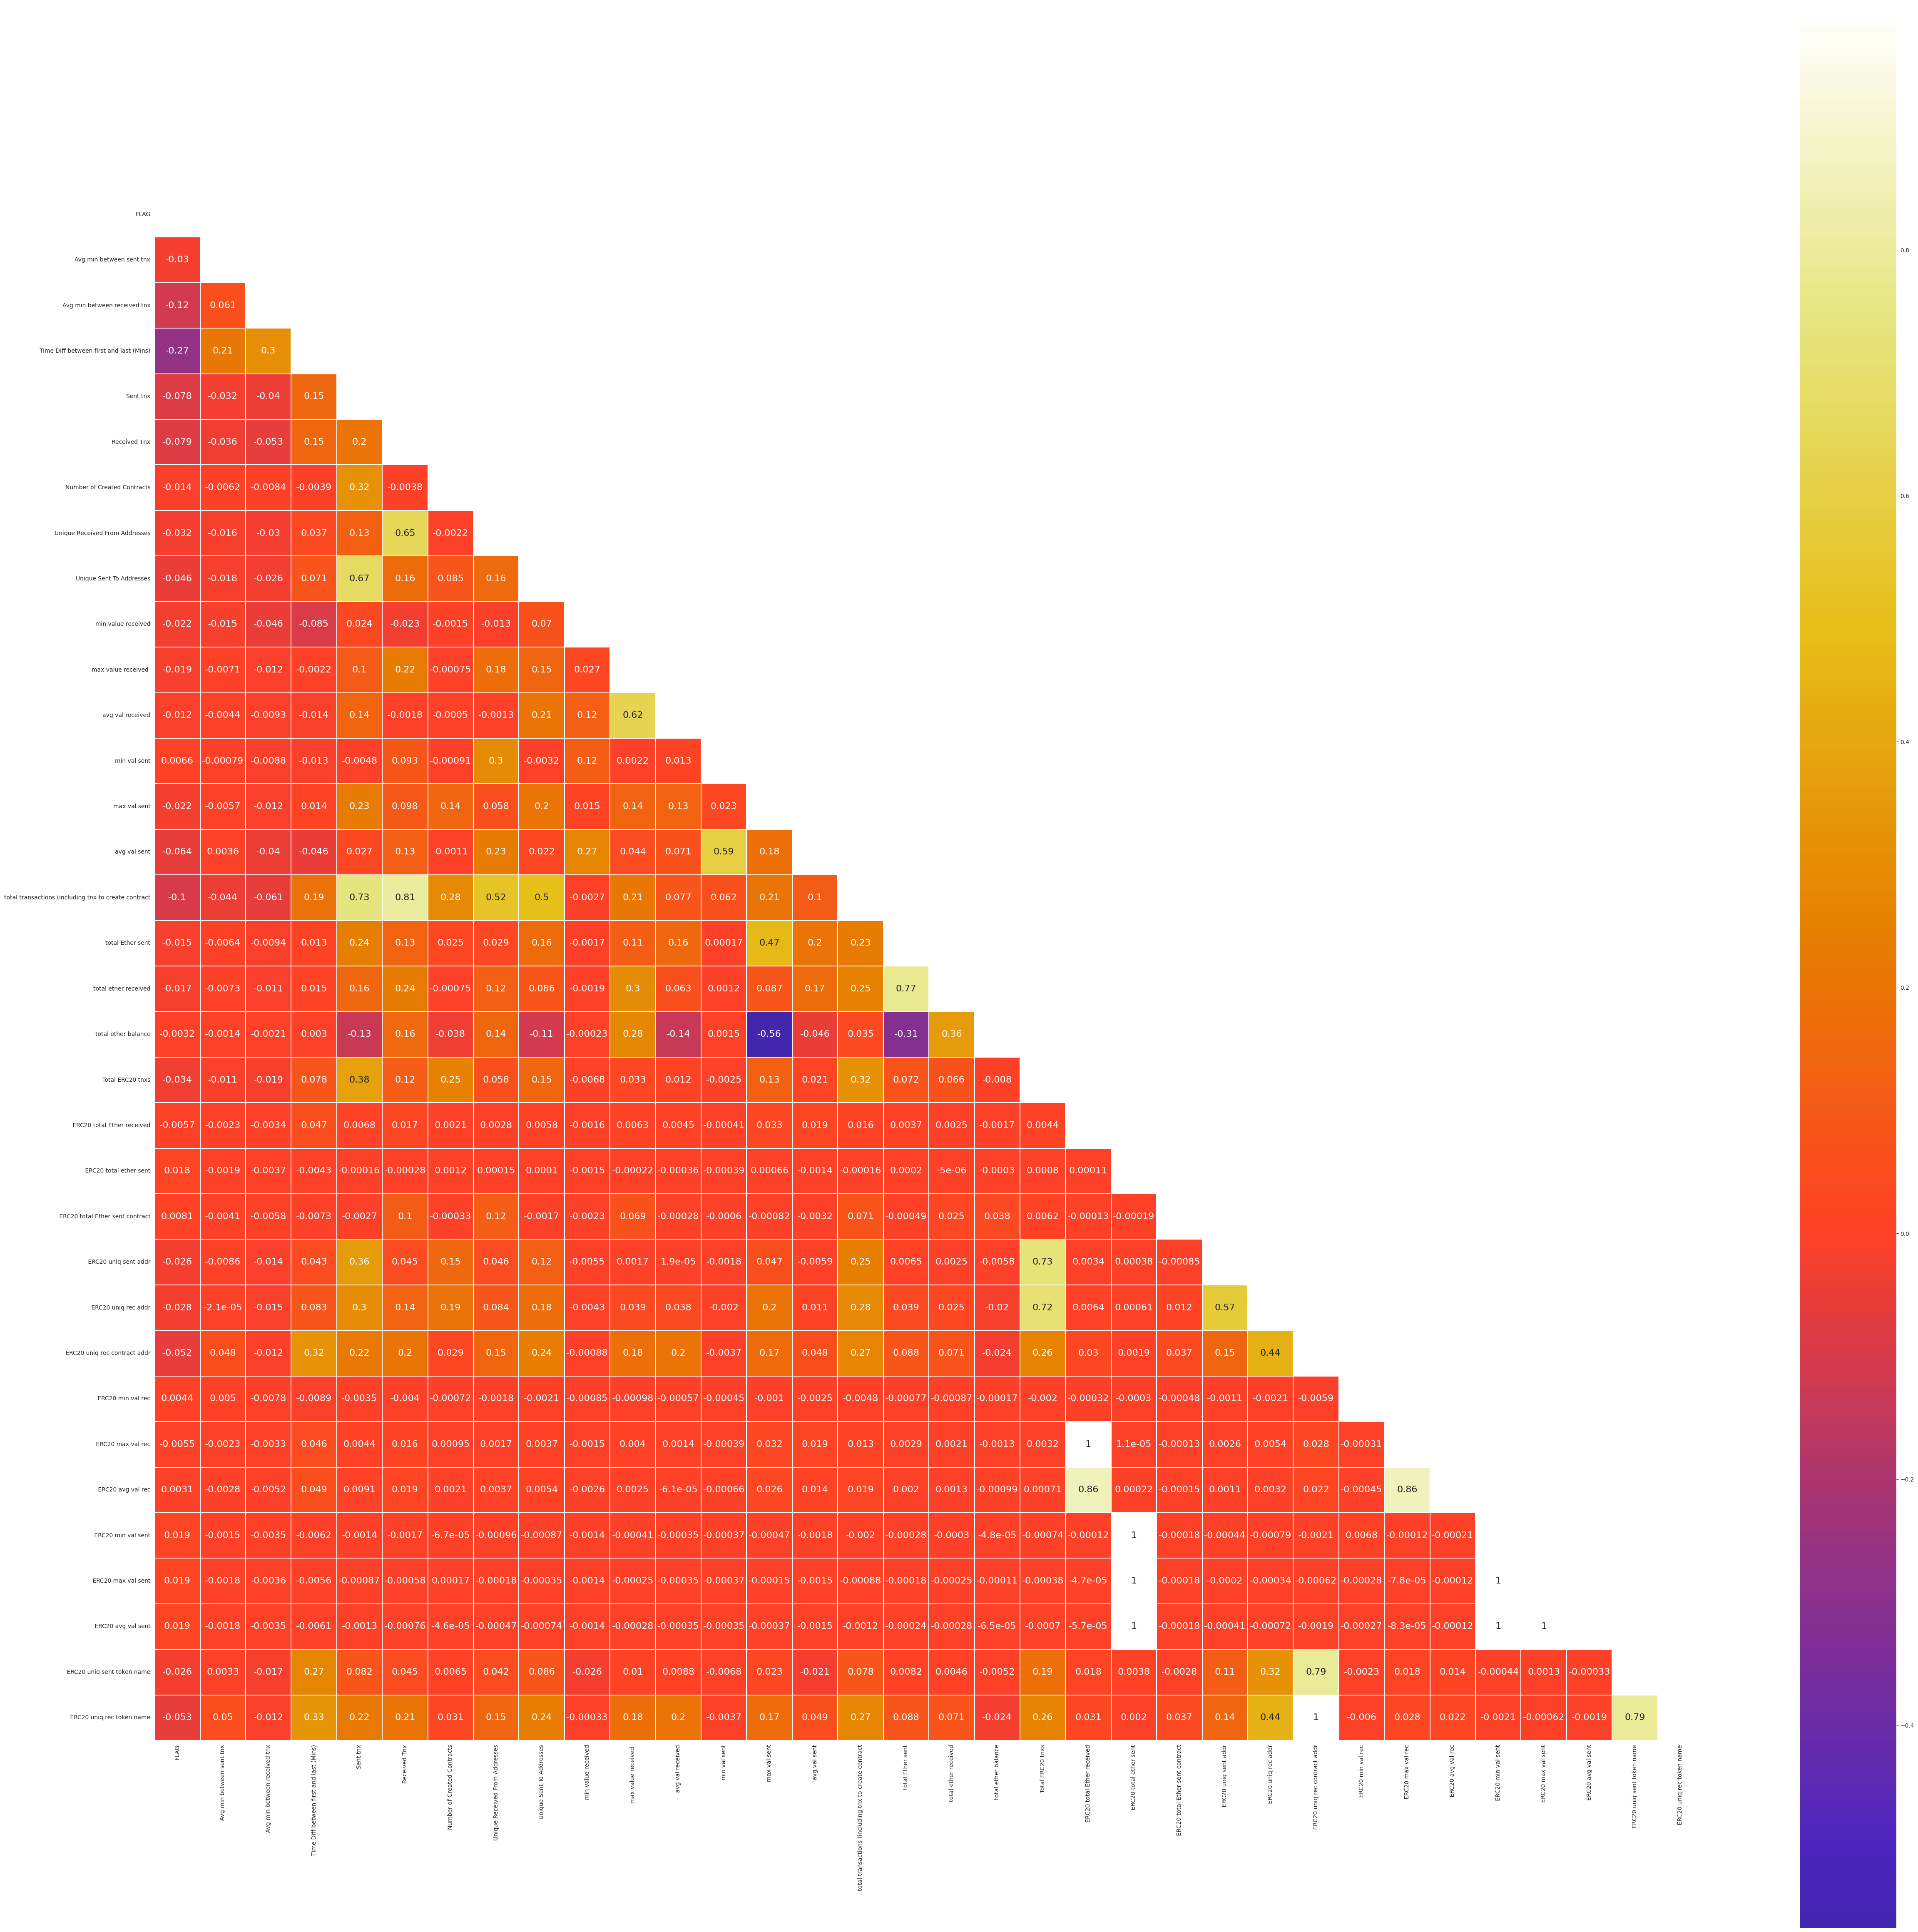

In [42]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(60,60))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 16})

It can be observed that some features in the current dataset is highly correlated. These features would equally contribute in the development of the model hence such duplicate features can be removed from the dataset in order to reduce the dimension of the dataset.

In [43]:
drop = ['total transactions (including tnx to create contract',
        ' ERC20 avg val rec',
        ' ERC20 avg val rec',
        ' ERC20 max val rec',
        ' ERC20 min val rec',
        ' ERC20 uniq rec contract addr',
        'max val sent',
        ' ERC20 avg val sent',
        ' ERC20 min val sent',
        ' ERC20 max val sent',
        ' Total ERC20 tnxs',
        'Unique Sent To Addresses',
        'Unique Received From Addresses',
        'total ether received',
        ' ERC20 uniq sent token name',
        'min value received',
        'min val sent',
        ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

Recheck the correlation matrix.

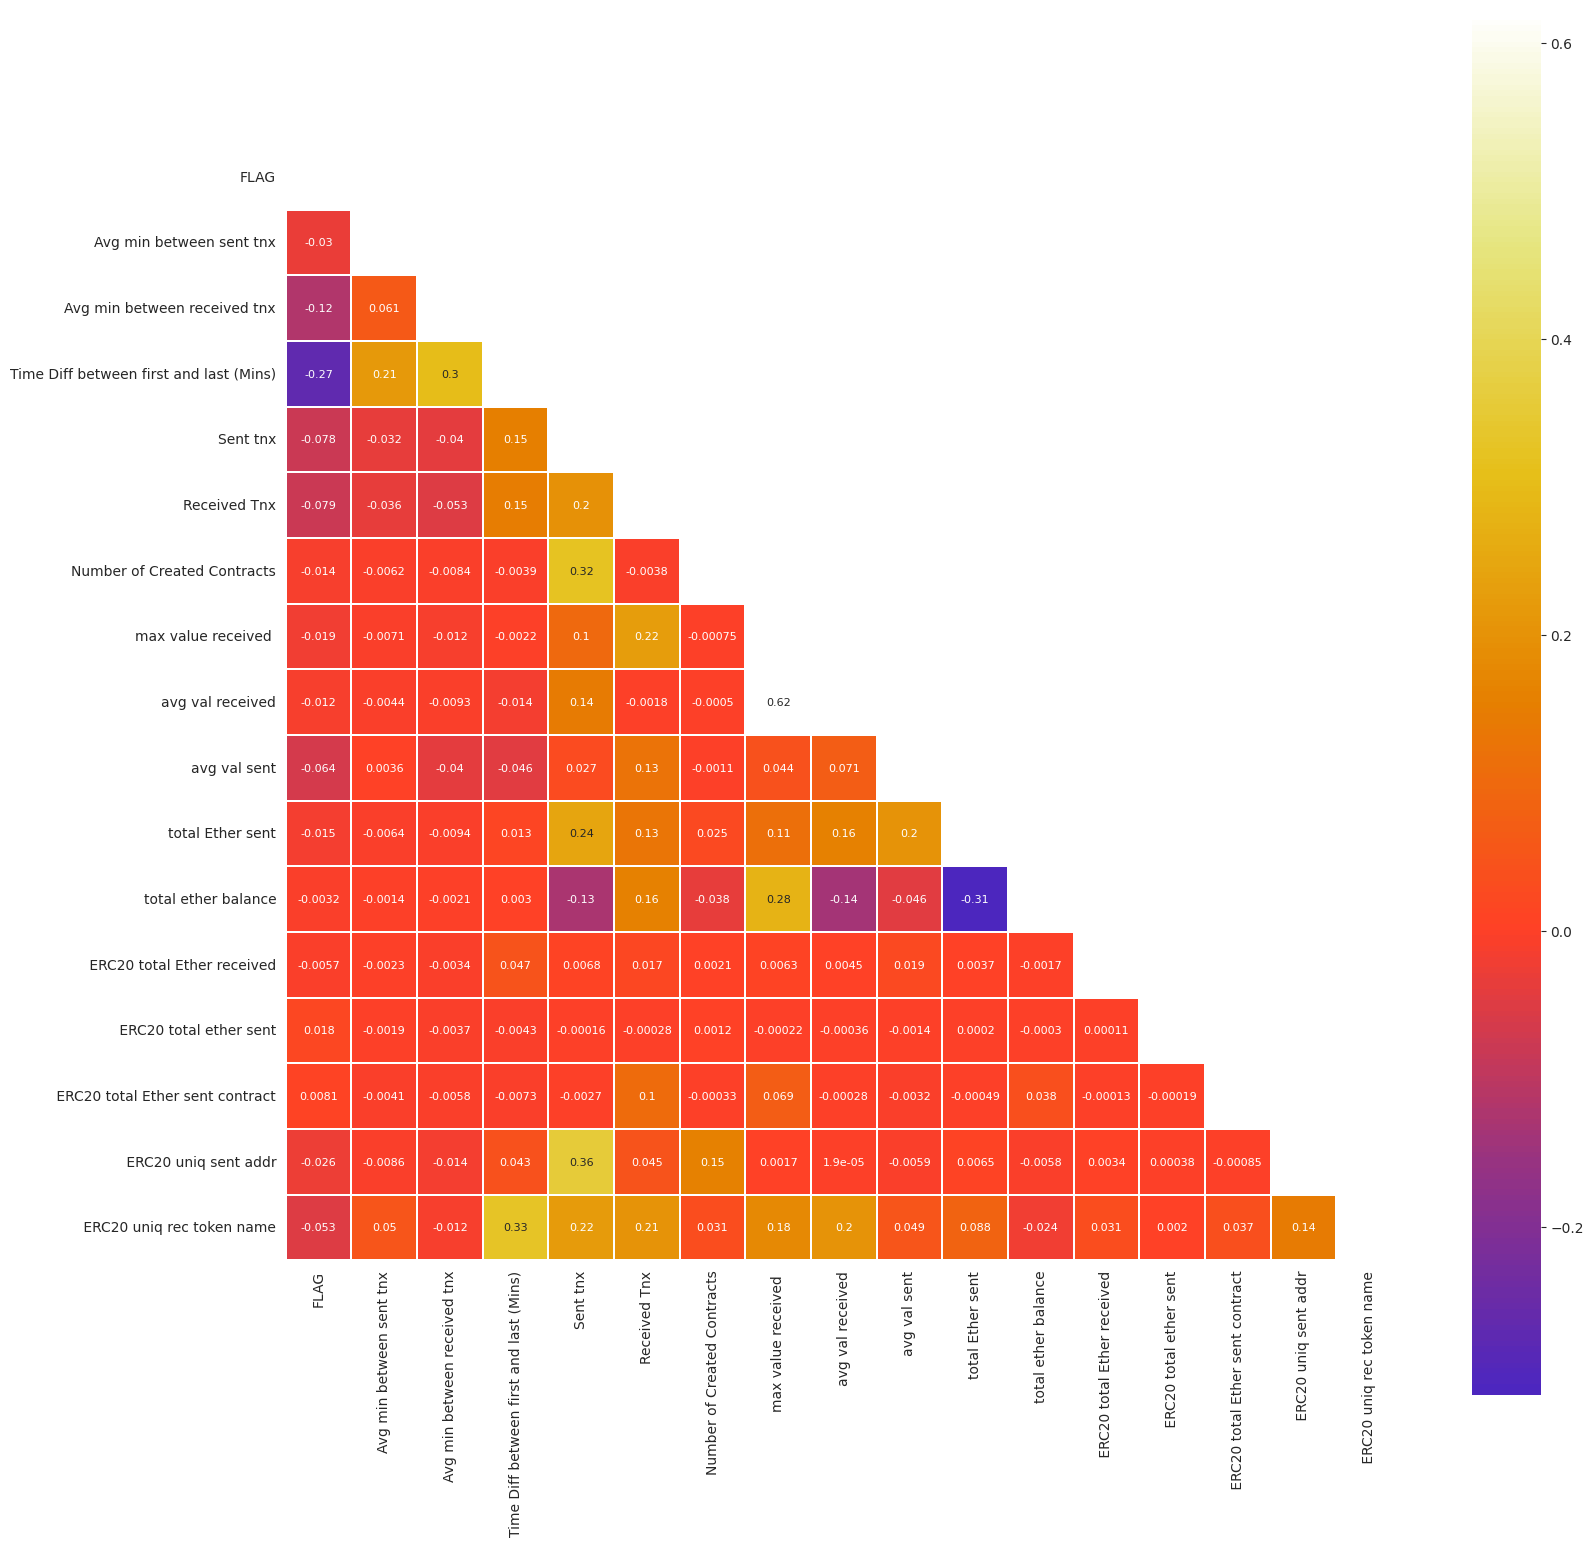

In [44]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(corr,  mask=mask, annot=True, cmap='CMRmap', center=0, linewidths=0.1, square=True,annot_kws={"size": 8})

## Visualize & Handle outliers

Detecting and removing outliers from the dataset is an important task as it can skew the model to a biased predicted. Box Plots are the best possible way to visualize such outliers for every feature.

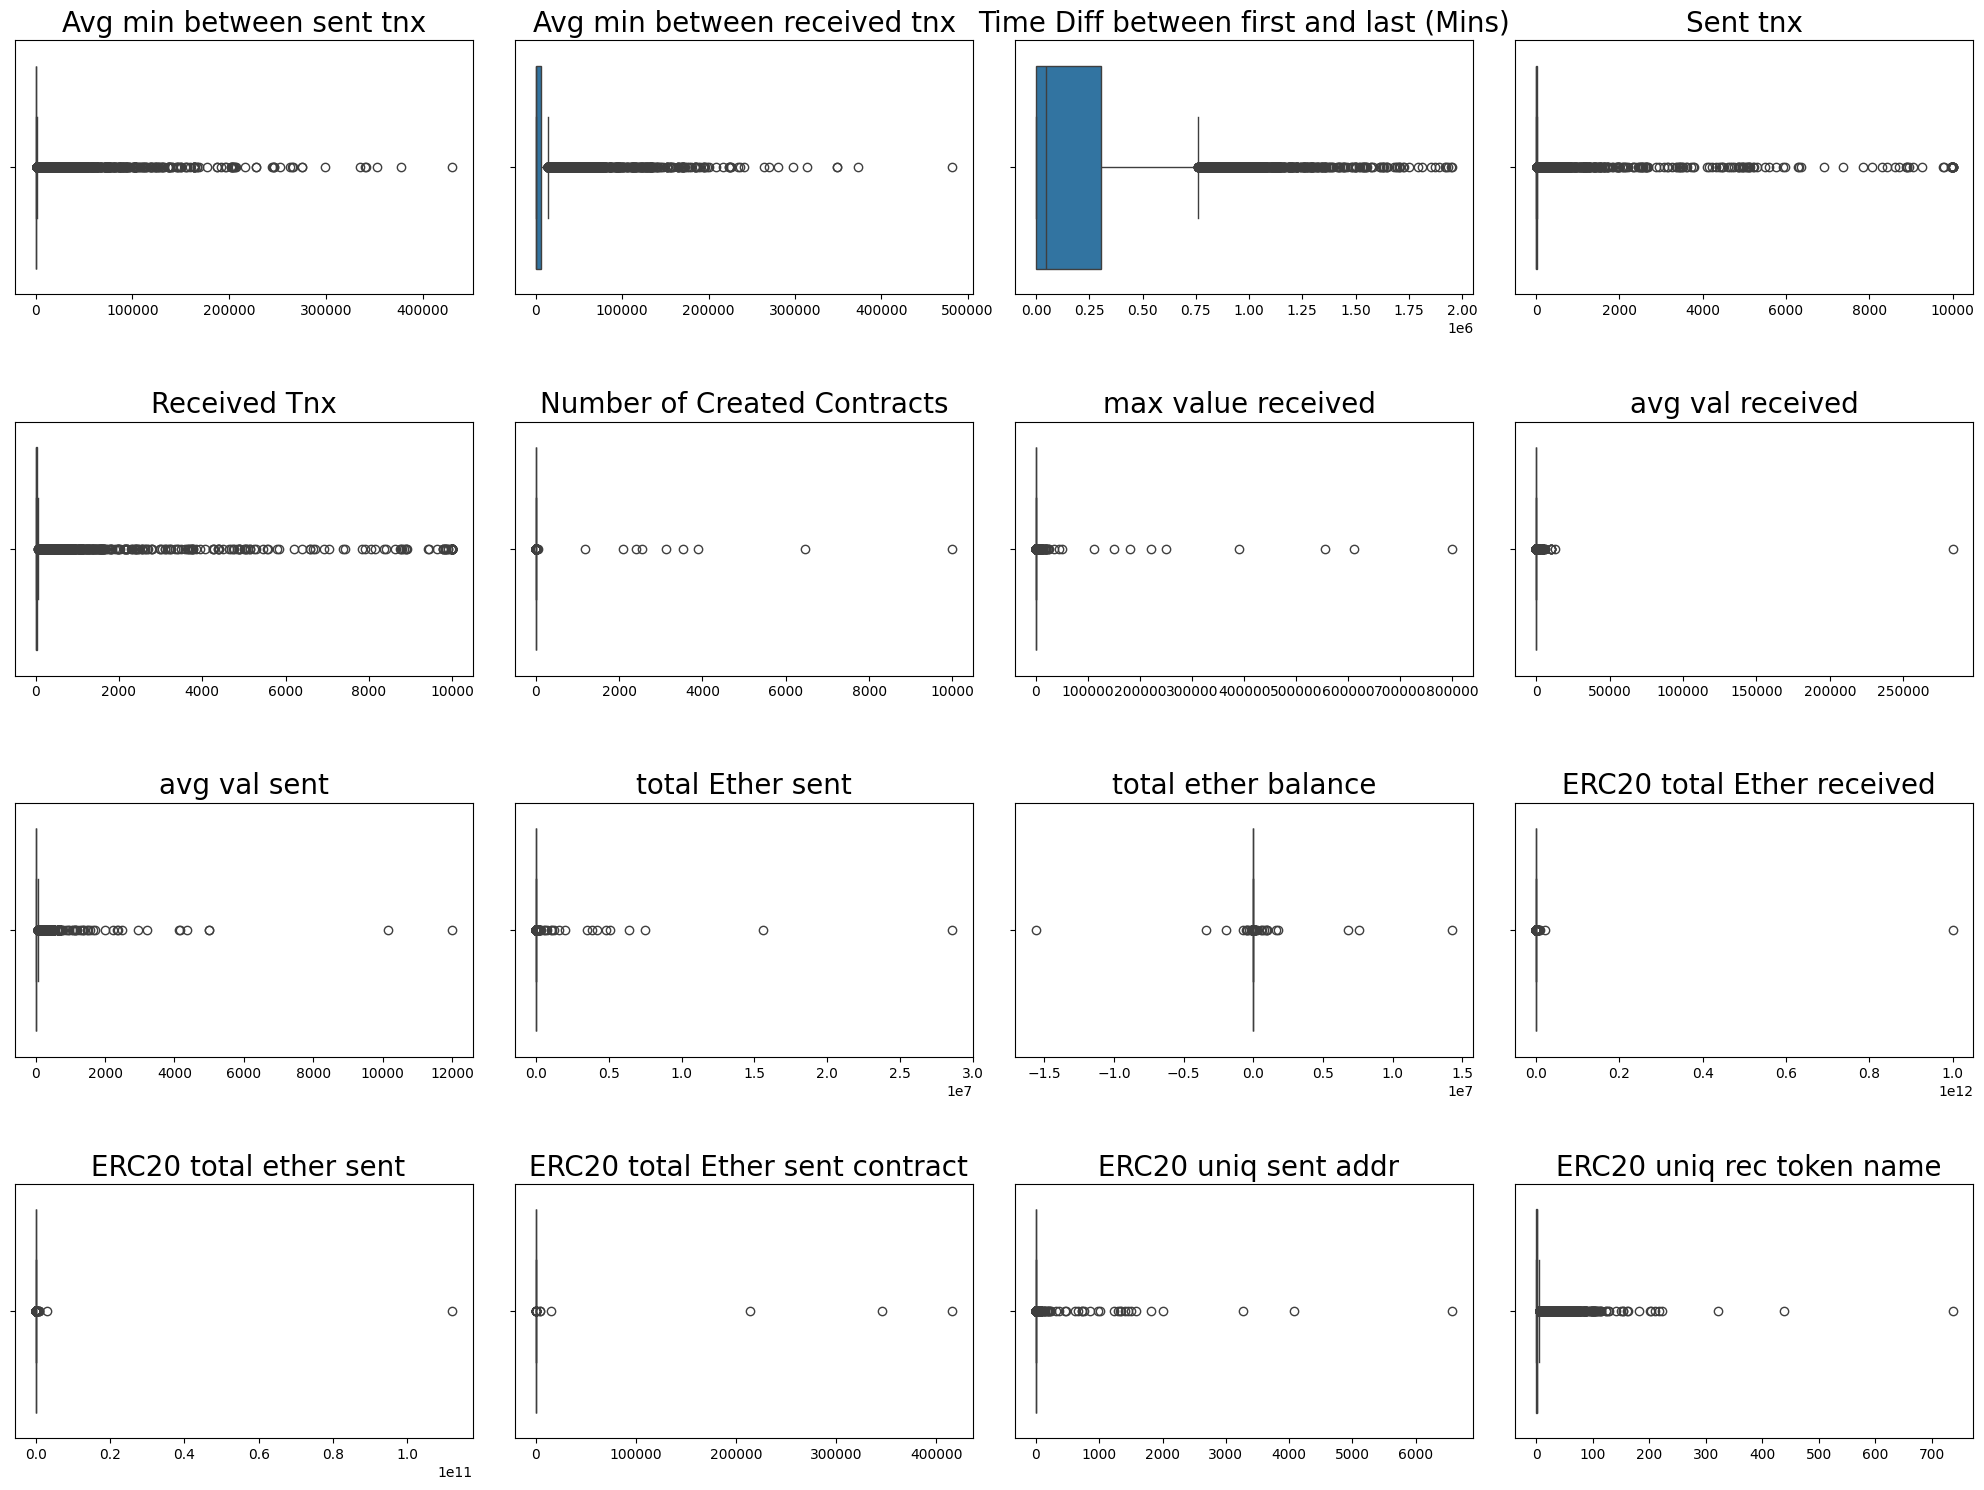

In [45]:
# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

# Iterate over features and create boxplots
features = df.columns[df.columns != 'FLAG']
for i, feature in enumerate(features):
    row = i // 4
    col = i % 4
    sns.boxplot(x=df[feature], ax=axes[row, col])
    axes[row, col].set_title(feature, fontsize=20)
    axes[row, col].set_xlabel('',)

# Adjust layout and add space between rows
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)  # Increase space between rows

# Display plot
plt.show()

## Rename Features

Renaming features would make further processing easy and structure.

In [46]:
df.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'total Ether sent',
       'total ether balance', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec token name'],
      dtype='object')

In [47]:
df.rename(columns={'FLAG': 'flag',
                   'Avg min between sent tnx': 'avg_min_between_sent_tnx',
                   'Avg min between received tnx': 'avg_min_between_received_tnx',
                   'Time Diff between first and last (Mins)': 'time_diff_between_first_and_last_in_mins',
                   'Sent tnx': 'sent_tnx',
                   'Received Tnx': 'received_tnx',
                   'Number of Created Contracts': 'number_of_created_contracts',
                   'max value received ': 'max_value_received',
                   'avg val received': 'avg_val_received',
                   'avg val sent': 'avg_val_sent',
                   'total Ether sent': 'total_ether_sent',
                   'total ether balance': 'total_ether_balance',
                   ' ERC20 total Ether received': 'erc20_total_ether_received',
                   ' ERC20 total ether sent': 'erc20_total_ether_sent',
                   ' ERC20 total Ether sent contract': 'erc20_total_ether_sent_contract',
                   ' ERC20 uniq sent addr': 'erc20_uniq_sent_addr',
                   ' ERC20 uniq rec token name': 'erc20_uniq_rec_token_name',
                   }, inplace=True)
df.columns


Index(['flag', 'avg_min_between_sent_tnx', 'avg_min_between_received_tnx',
       'time_diff_between_first_and_last_in_mins', 'sent_tnx', 'received_tnx',
       'number_of_created_contracts', 'max_value_received', 'avg_val_received',
       'avg_val_sent', 'total_ether_sent', 'total_ether_balance',
       'erc20_total_ether_received', 'erc20_total_ether_sent',
       'erc20_total_ether_sent_contract', 'erc20_uniq_sent_addr',
       'erc20_uniq_rec_token_name'],
      dtype='object')

## Save the cleaned Dataset

Creating a copy of the cleaned datset is always a wise practise to perform.

In [ ]:
cleaned_df = df.copy()

# Data Pre-Processing

## Seperate independent and dependent features

In [48]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

print(X.shape, y.shape)

(9841, 16) (9841,)


## Normalize Dataset

As visualised earlier, the scale of all the features varies in all contexts. In order to fix it normalisation of features is required.

In [49]:
# Normalize the independent features
norm = PowerTransformer()
X_norm = norm.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
X_norm.head()

,avg_min_between_sent_tnx,avg_min_between_received_tnx,time_diff_between_first_and_last_in_mins,sent_tnx,received_tnx,number_of_created_contracts,max_value_received,avg_val_received,avg_val_sent,total_ether_sent,total_ether_balance,erc20_total_ether_received,erc20_total_ether_sent,erc20_total_ether_sent_contract,erc20_uniq_sent_addr,erc20_uniq_rec_token_name
0,0.996239,0.463574,1.194228,1.902089,1.289354,-0.399764,0.820605,0.466701,-0.345094,1.384648,-0.006453,1.862055,2.521636,-0.035957,2.409234,1.897965
1,1.463276,0.717357,1.422968,1.533728,0.223306,-0.399764,-0.469944,-0.906854,-1.101082,-0.495493,-0.005287,1.457638,1.249076,-0.035957,2.120794,1.403683
2,1.826552,0.667180,1.070533,-0.211835,0.348591,-0.399764,-0.814859,-0.928037,-0.144595,-0.439272,-0.005287,1.489080,-0.408115,-0.035957,-0.434442,1.457654
3,1.431088,1.156298,0.969309,1.112440,0.290037,-0.399764,1.556920,1.447404,1.425104,1.546732,-0.008864,1.742155,2.517629,-0.035957,2.333623,1.571092
4,0.233867,1.053220,0.954623,2.069363,0.704083,2.501365,0.285223,-0.018784,-1.112322,0.798127,-0.005499,1.808245,2.520900,-0.035957,2.395259,1.792788


## Train, Validate, Test Split

The dataset is divided in the following parts:
*   Training(70%) - Used purely for training the model
*   Validation(10%) - Used only for selecting a model
*   Testing(20%) - Used to test the final model

Stratification would be applied in order to make sure that the class is equally distributed in all the data set.



In [50]:
X_norm.shape, y.shape

((9841, 16), (9841,))

In [51]:
# Split the dataset into training (70%) and remaining (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(X_norm, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation (10% of original) and test (20% of original)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=2/3, stratify=y_remaining, random_state=42)

# Display the shapes of the datasets
X_train.shape, X_val.shape, X_test.shape

((6888, 16), (984, 16), (1969, 16))

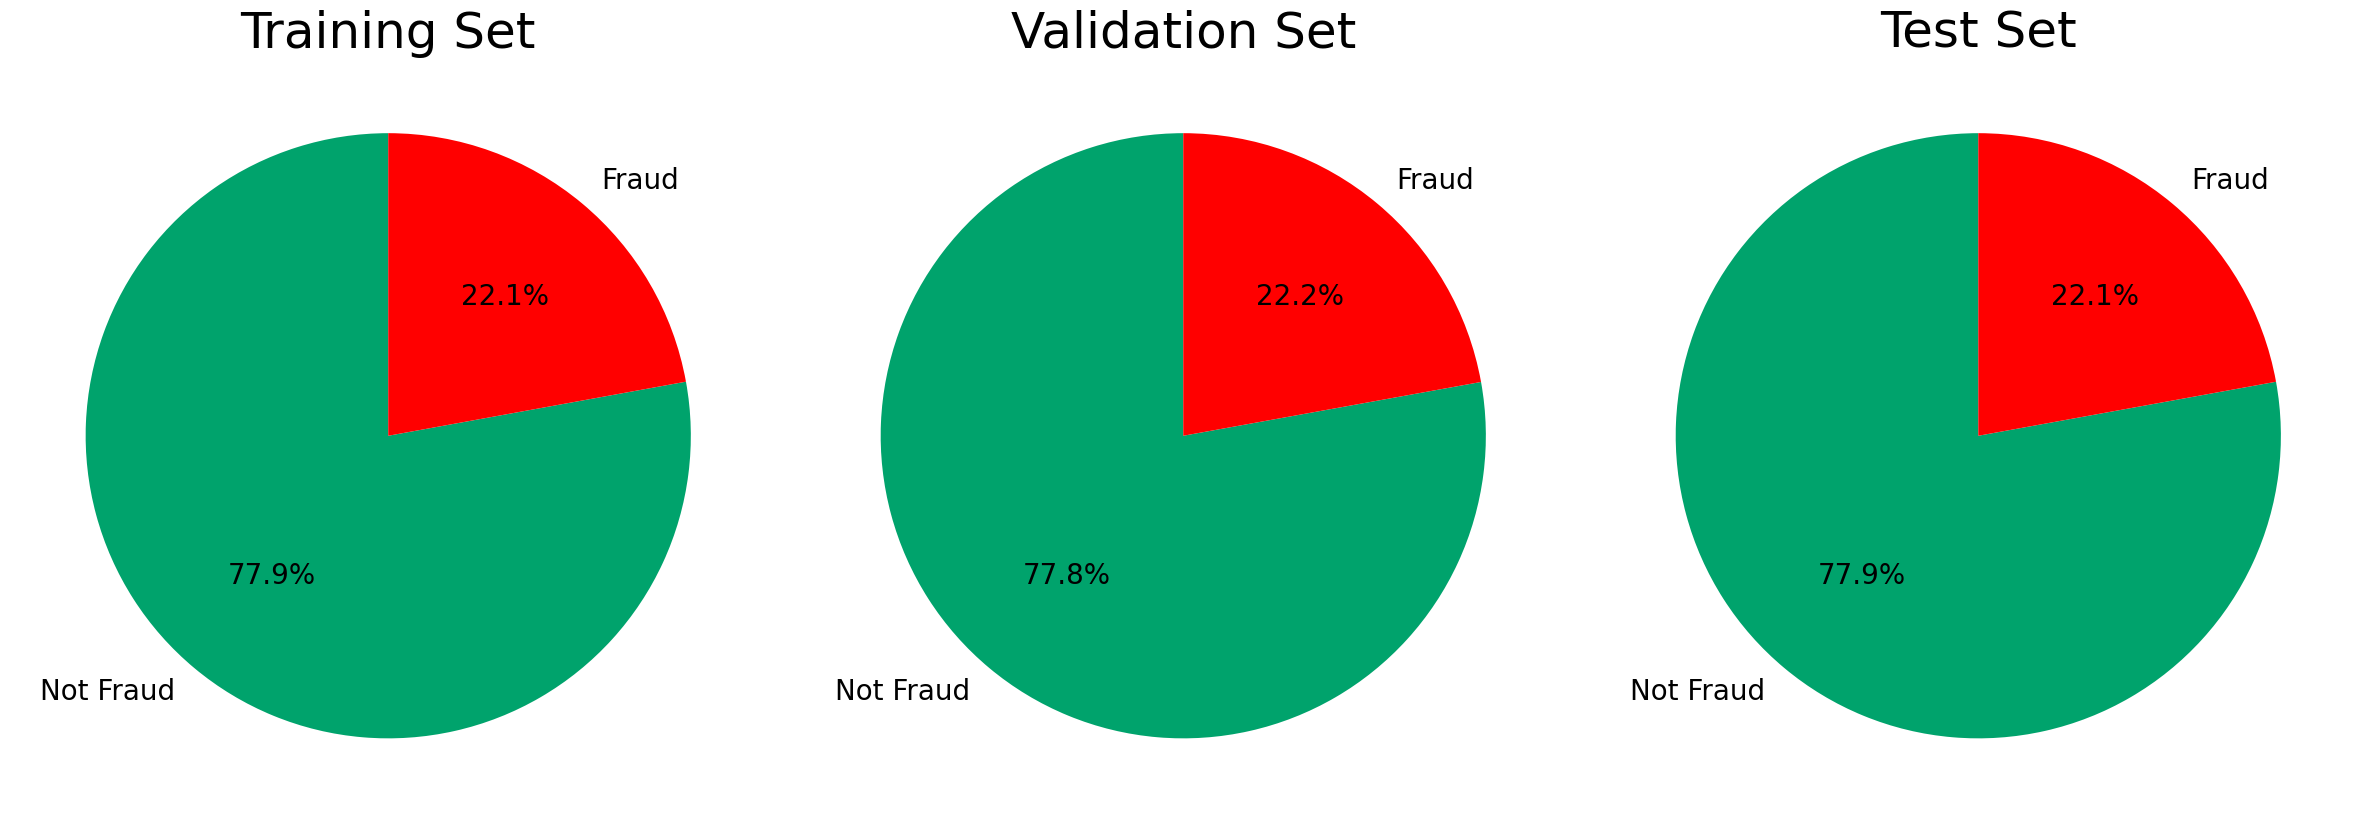

In [52]:
colors = ['#00A36C', '#FF0000']  # Green for 'Not Fraud', Red for 'Fraud'

# Create three subplots in an horizontal alignment
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot for training set
axes[0].pie(y_train.value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[0].set_title('Training Set', fontsize=36)

# Plot for validation set
axes[1].pie(y_val.value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[1].set_title('Validation Set', fontsize=36)

# Plot for test set
axes[2].pie(y_test.value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[2].set_title('Test Set', fontsize=36)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


As show in the figure, stratification makes sure that the ratio is equal in all the sets.

## Oversampling - SMOTE

To overcome the bias while building the model, it's important to address the class imbalance. This would be achieved by Synthetic Minority Oversampling Technique and later it would be compared with the a novel technique.

In [53]:
oversample = SMOTE()
print(f'Shape of the training set before SMOTE: {X_train.shape, y_train.shape}')

X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)
print(f'Shape of the training set after SMOTE: {X_train_resample.shape, y_train_resample.shape}')

print(f'Shape of the validation set before SMOTE: {X_val.shape, y_val.shape}')

X_val_resample, y_val_resample = oversample.fit_resample(X_val, y_val)
print(f'Shape of the validation set after SMOTE: {X_val_resample.shape, y_val_resample.shape}')

Shape of the training set before SMOTE: ((6888, 16), (6888,))
Shape of the training set after SMOTE: ((10726, 16), (10726,))
Shape of the validation set before SMOTE: ((984, 16), (984,))
Shape of the validation set after SMOTE: ((1532, 16), (1532,))


Text(0.5, 1.0, 'Balanced Validation Set')

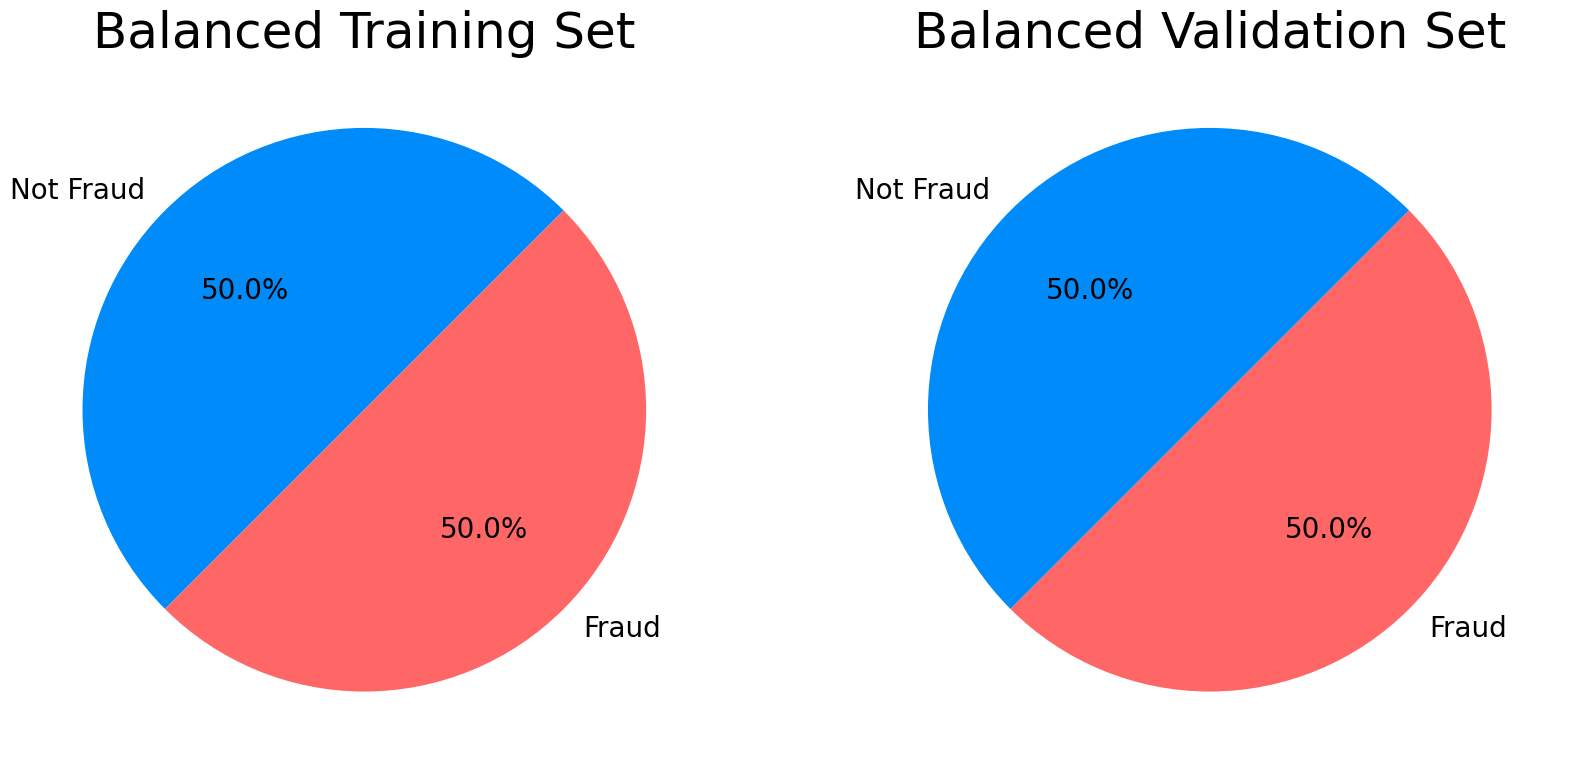

In [54]:
colors = ['#008BFB', '#FF6666']  # Green for 'Not Fraud', Red for 'Fraud'

# Create a three subplots in horizontal alignment
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize as needed

# Plot for training set
axes[0].pie(y_train_resample.value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=45,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[0].set_title('Balanced Training Set', fontsize=36)

# Plot for validation set
axes[1].pie(y_val_resample.value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=45,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[1].set_title('Balanced Validation Set', fontsize=36)

In [55]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_train:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_train_resample:
    if j == 0:
        no +=1
    else:
        yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 5363 
 	Fauds: 1525
AFTER OVERSAMPLING 
 	Non-frauds: 5363 
 	Fauds: 5364


# GAN synth data generation

Generative Adversarial Network consists of two competing neural
networks: the generator and the discriminator.
* The generator’s task is to create synthetic data that closely
mimics the real data distribution.
* The discriminator's role is to distinguish between real and synthetic data.

The upcoming sections were run using external GPUs provided by the University of Stirling's Technical team. This was done in order to reduc the setup and training time.

## SetUp GAN

In [ ]:
# # Define the generator model
# def build_generator(latent_dim, n_features):
#     model = tf.keras.Sequential([
#         layers.Dense(64, activation='relu', input_dim=latent_dim),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(n_features, activation='sigmoid')
#     ])
#     return model

# # Define the discriminator model
# def build_discriminator(n_features):
#     model = tf.keras.Sequential([
#         layers.Dense(256, activation='relu', input_dim=n_features),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model

## Build GAN Model

In [ ]:
# def build_gan(generator, discriminator):
#     discriminator.trainable = False
#     gan_input = layers.Input(shape=(latent_dim,))
#     gan_output = discriminator(generator(gan_input))
#     gan = tf.keras.Model(gan_input, gan_output)
#     gan.compile(optimizer='adam', loss='binary_crossentropy')
#     return gan

# gan = build_gan(generator, discriminator)

## Train GAN Model

In [ ]:
# # Train the GAN
# def train_gan(gan, generator, discriminator, X_fraud, epochs=100, batch_size=64):
#     half_batch = batch_size // 2
#     for epoch in range(epochs):
#         idx = np.random.randint(0, X_fraud.shape[0], half_batch)
#         real_data = X_fraud.iloc[idx]
#         real_labels = np.ones((half_batch, 1))
#         d_loss_real = discriminator.train_on_batch(real_data, real_labels)

#         noise = np.random.normal(0, 1, (half_batch, latent_dim))
#         fake_data = generator.predict(noise)
#         fake_labels = np.zeros((half_batch, 1))
#         d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)

#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         valid_y = np.ones((batch_size, 1))
#         g_loss = gan.train_on_batch(noise, valid_y)

# train_gan(gan, generator, discriminator, X_train[y_train == 1])

## Load GAN

The trained and built model was saved on the drive for easy access.

In [57]:
generator = load_model('/content/drive/My Drive/generator_model.h5', compile=False)

In [58]:
# GAN setup configurations
latent_dim = 32
n_features = X_train.shape[1]

# Generate synthetic fraud data
def generate_synthetic_fraud(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data

# Number of synthetic samples to generate
n_synthetic_train = len(y_train[y_train == 0]) - len(y_train[y_train == 1])

# Generate and augment training set
synthetic_fraud_train = generate_synthetic_fraud(generator, n_synthetic_train)
X_train_balanced = np.vstack((X_train, synthetic_fraud_train))
y_train_balanced = np.hstack((y_train, np.ones(n_synthetic_train)))

n_synthetic_val = len(y_val[y_val == 0]) - len(y_val[y_val == 1])
# Generate and augment validation set
synthetic_fraud_val = generate_synthetic_fraud(generator, n_synthetic_val)
X_val_balanced = np.vstack((X_val, synthetic_fraud_val))
y_val_balanced = np.hstack((y_val, np.ones(n_synthetic_val)))

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Text(0.5, 1.0, 'Augmented Validation Set')

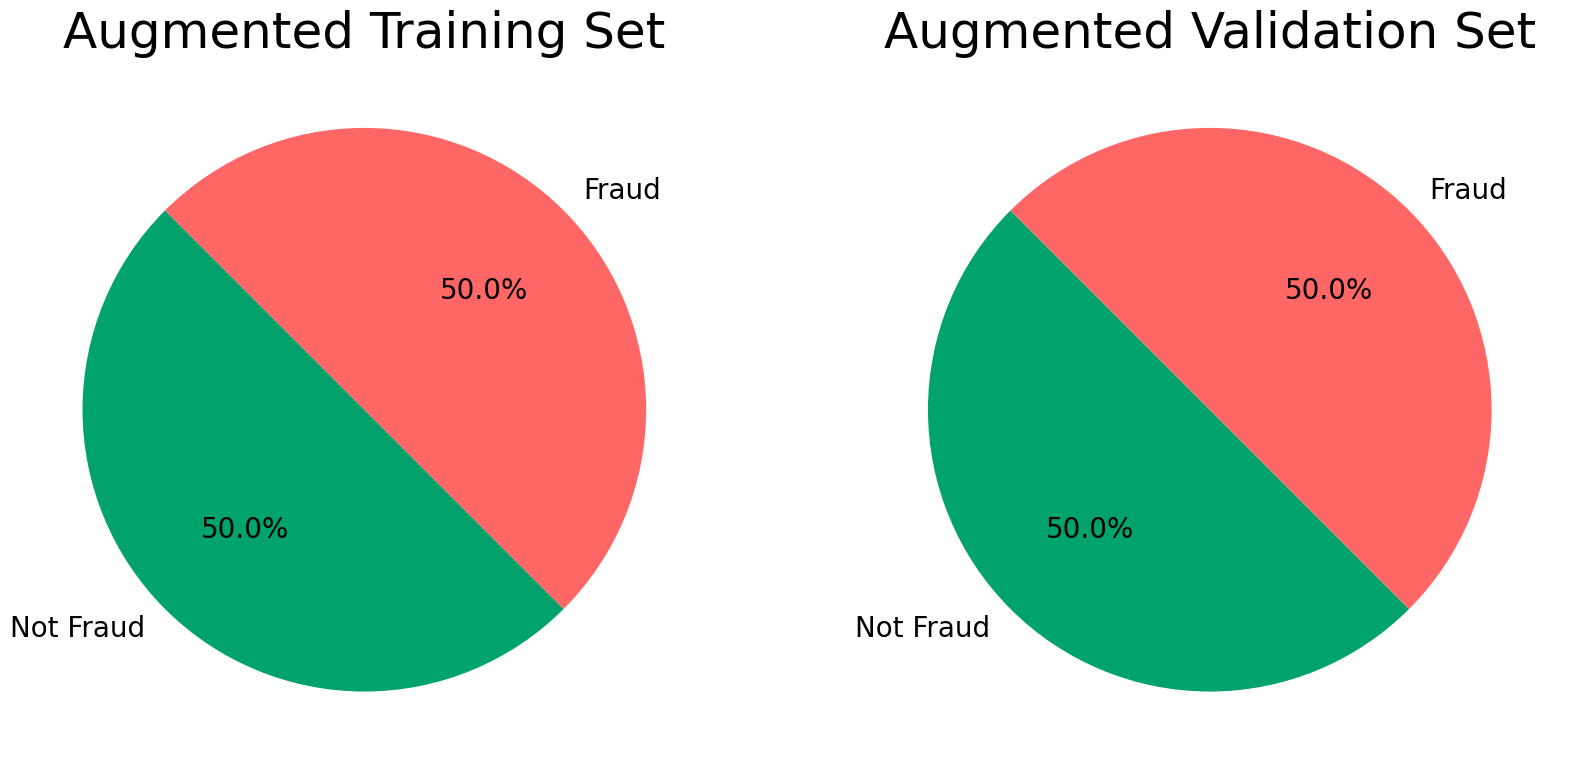

In [59]:
colors = ['#00A36C', '#FF6666']  # Green for 'Not Fraud', Red for 'Fraud'

# Subplots in horizontal alignment
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot for training set
axes[0].pie(pd.Series(y_train_balanced).value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=135,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[0].set_title('Augmented Training Set', fontsize=36)

# Plot for validation set
axes[1].pie(pd.Series(y_val_balanced).value_counts(),
            labels=['Not Fraud', 'Fraud'],
            autopct='%1.1f%%',
            startangle=135,
            colors=colors,
            textprops={'fontsize': 20},
            )
axes[1].set_title('Augmented Validation Set', fontsize=36)

# Model Building

## Genetic Algorithm Modelling

The Genetic Algorithm - Cuckoo Search (GA-CS) optimized Deep Learning framework is the current state-of-the-art for fraud detection in Ethereum.

The GA-CS algorithm integrates the
exploration capabilities of genetic algorithms with the exploitation strengths of cuckoo search, providing
a balanced optimization approach that effectively addresses the local optima trap and enhances
convergence speed.

The model setup, building, and training was performed using external GPUs provided by the University of Stirling. Hence, upon building the model, it was saved on google drive and retrieved from the same.

In [64]:
# # Define the deep learning model
# def create_model(input_dim):
#     model = Sequential([
#         Dense(64, activation='relu', input_shape=(input_dim,)),
#         BatchNormalization(),
#         Dense(32, activation='relu'),
#         BatchNormalization(),
#         Dense(16, activation='relu'),
#         BatchNormalization(),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [65]:
# # Define the GA-CS optimization algorithm
# class GA_CS:
#     def __init__(self, n_nests=80, n_eggs=10, n_generations=300, p_a_min=0.2, p_a_max=0.6,
#                  alpha=1.7, mutation_prob=0.03, crossover_rate=0.75):
#         self.n_nests = n_nests
#         self.n_eggs = n_eggs
#         self.n_generations = n_generations
#         self.p_a_min = p_a_min
#         self.p_a_max = p_a_max
#         self.alpha = alpha
#         self.mutation_prob = mutation_prob
#         self.crossover_rate = crossover_rate

#     def initialize_population(self, input_dim):
#         return [create_model(input_dim) for _ in range(self.n_nests)]

#     def fitness(self, model, X, y):
#         _, accuracy = model.evaluate(X, y, verbose=0)
#         return accuracy

#     def levy_flight(self):
#         return np.random.standard_cauchy()

#     def get_cuckoo(self, model):
#         new_model = create_model(model.input_shape[1])
#         for i, layer in enumerate(model.layers):
#             if isinstance(layer, Dense):
#                 weights = layer.get_weights()
#                 new_weights = [w + self.levy_flight() * self.alpha * np.random.randn(*w.shape) for w in weights]
#                 new_model.layers[i].set_weights(new_weights)
#         return new_model

#     def crossover(self, model1, model2):
#         new_model = create_model(model1.input_shape[1])
#         for i, layer in enumerate(new_model.layers):
#             if isinstance(layer, Dense):
#                 weights1 = model1.layers[i].get_weights()
#                 weights2 = model2.layers[i].get_weights()
#                 new_weights = []
#                 for w1, w2 in zip(weights1, weights2):
#                     mask = np.random.random(w1.shape) < self.crossover_rate
#                     new_w = np.where(mask, w1, w2)
#                     new_weights.append(new_w)
#                 layer.set_weights(new_weights)
#         return new_model

#     def mutate(self, model):
#         for layer in model.layers:
#             if isinstance(layer, Dense):
#                 weights = layer.get_weights()
#                 mutated_weights = []
#                 for w in weights:
#                     mask = np.random.random(w.shape) < self.mutation_prob
#                     mutation = np.random.normal(0, 0.1, w.shape)
#                     mutated_w = np.where(mask, w + mutation, w)
#                     mutated_weights.append(mutated_w)
#                 layer.set_weights(mutated_weights)
#         return model

#     def optimize(self, X, y):
#         population = self.initialize_population(X.shape[1])
#         best_model = None
#         best_fitness = 0

#         for generation in range(self.n_generations):
#             p_a = self.p_a_max - (self.p_a_max - self.p_a_min) * generation / self.n_generations

#             for i in range(self.n_nests):
#                 cuckoo = self.get_cuckoo(population[i])
#                 cuckoo_fitness = self.fitness(cuckoo, X, y)

#                 j = np.random.randint(self.n_nests)
#                 if cuckoo_fitness > self.fitness(population[j], X, y):
#                     population[j] = cuckoo

#                 if np.random.random() < p_a:
#                     population[i] = self.mutate(self.crossover(population[i], population[np.random.randint(self.n_nests)]))

#             fitnesses = [self.fitness(model, X, y) for model in population]
#             best_idx = np.argmax(fitnesses)

#             if fitnesses[best_idx] > best_fitness:
#                 best_fitness = fitnesses[best_idx]
#                 best_model = population[best_idx]

#             print(f"Generation {generation + 1}/{self.n_generations}, Best Fitness: {best_fitness}")

#         return best_model, best_fitness

In [66]:
# # Run the GA-CS optimization
# optimizer = GA_CS()
# best_model, best_fitness = optimizer.optimize(X_train_resample, y_train_resample)

In [67]:
genetic_model = load_model('/content/drive/My Drive/genetic_model.h5', compile=False)

## Modelling

All off-the-shelf algorithms are imported and defined in the ***classifiers*** dictionary along with the GA-CS algorithm.

In [69]:
# Define all the classifiers used in this research
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LGBM": lgb.LGBMClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Genetic Algorithm": genetic_model,
}

All the models would be trained seperately for SMOTE and GAN generated synthetic data for futher comparison.

In [70]:
# Containers for metrics
smote_accuracy = []
smote_precision = []
smote_recall = []
smote_f1score = []

gan_accuracy = []
gan_precision = []
gan_recall = []
gan_f1score = []

# Loop through classifiers
for name, clf in classifiers.items():
    # SMOTE Modelling
    if name != 'Genetic Algorithm':
      clf.fit(X_train_resample, y_train_resample)

    y_pred = clf.predict(X_val_resample)
    report = classification_report(y_val_resample, y_pred, output_dict=True)

    smote_accuracy.append(report["accuracy"] * 100)
    smote_precision.append(report["macro avg"]["precision"] * 100)
    smote_recall.append(report["macro avg"]["recall"] * 100)
    smote_f1score.append(report["macro avg"]["f1-score"] * 100)


    # GAN Modelling
    if name != 'Genetic Algorithm':
      clf.fit(X_train_balanced, y_train_balanced)


    y_pred = clf.predict(X_val_balanced)
    report = classification_report(y_val_balanced, y_pred, output_dict=True)

    gan_accuracy.append(report["accuracy"] * 100)
    gan_precision.append(report["macro avg"]["precision"] * 100)
    gan_recall.append(report["macro avg"]["recall"] * 100)
    gan_f1score.append(report["macro avg"]["f1-score"] * 100)

[LightGBM] [Info] Number of positive: 5363, number of negative: 5363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3540
[LightGBM] [Info] Number of data points in the train set: 10726, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 5363, number of negative: 5363
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3912
[LightGBM] [Info] Number of data points in the train set: 10726, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [71]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Model': list(classifiers.keys()),
    'SMOTE_Recall': [round(x, 2) for x in smote_recall],
    'GAN_Recall': [round(x, 2) for x in gan_recall],
    'SMOTE_F1_Score': [round(x, 2) for x in smote_f1score],
    'GAN_F1_Score': [round(x, 2) for x in gan_f1score],
    'SMOTE_Precision': [round(x, 2) for x in smote_precision],
    'GAN_Precision': [round(x, 2) for x in gan_precision],
    'SMOTE_Accuracy': [round(x, 2) for x in smote_accuracy],
    'GAN_Accuracy': [round(x, 2) for x in gan_accuracy],
})

# Display the results
print(results_df)

                 Model  SMOTE_Recall  GAN_Recall  SMOTE_F1_Score  \
0  Logistic Regression         88.38       93.54           88.38   
1                  SVC         95.30       97.45           95.30   
2                  KNN         95.30       97.06           95.30   
3        Decision Tree         95.76       97.00           95.76   
4        Random Forest         96.41       97.98           96.41   
5              XGBoost         96.80       98.30           96.80   
6                 LGBM         96.93       98.69           96.93   
7             AdaBoost         94.65       96.08           94.65   
8    Genetic Algorithm         89.36       95.30           89.32   

   GAN_F1_Score  SMOTE_Precision  GAN_Precision  SMOTE_Accuracy  GAN_Accuracy  
0         93.54            88.39          93.58           88.38         93.54  
1         97.45            95.31          97.47           95.30         97.45  
2         97.06            95.31          97.09           95.30         97.06  

## Best Model Evaluation

All the above trained classifiers are evaluated on their Recall, F1_Score, Precision, and Accuracy and compared for SMOTE and GAN datasets.

In [72]:
algorithms = list(classifiers.keys())

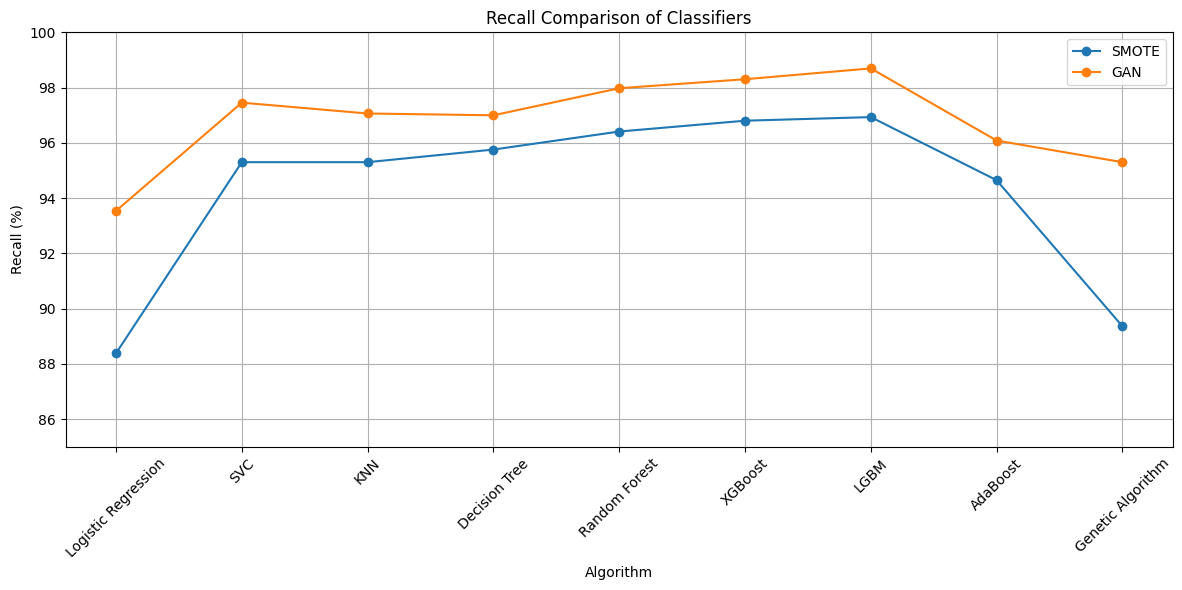

In [73]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(algorithms, smote_recall, marker='o', label='SMOTE')
plt.plot(algorithms, gan_recall, marker='o', label='GAN')

plt.title('Recall Comparison of Classifiers')
plt.xlabel('Algorithm')
plt.ylabel('Recall (%)')
plt.ylim(85, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

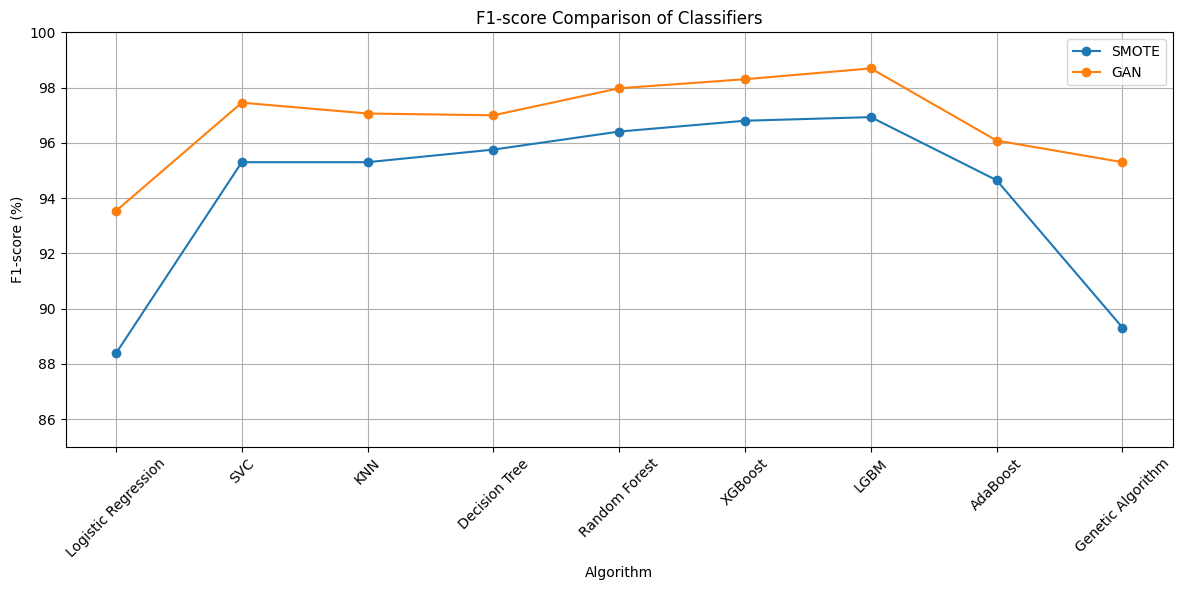

In [74]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(algorithms, smote_f1score, marker='o', label='SMOTE')
plt.plot(algorithms, gan_f1score, marker='o', label='GAN')

plt.title('F1-score Comparison of Classifiers')
plt.xlabel('Algorithm')
plt.ylabel('F1-score (%)')
plt.ylim(85, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

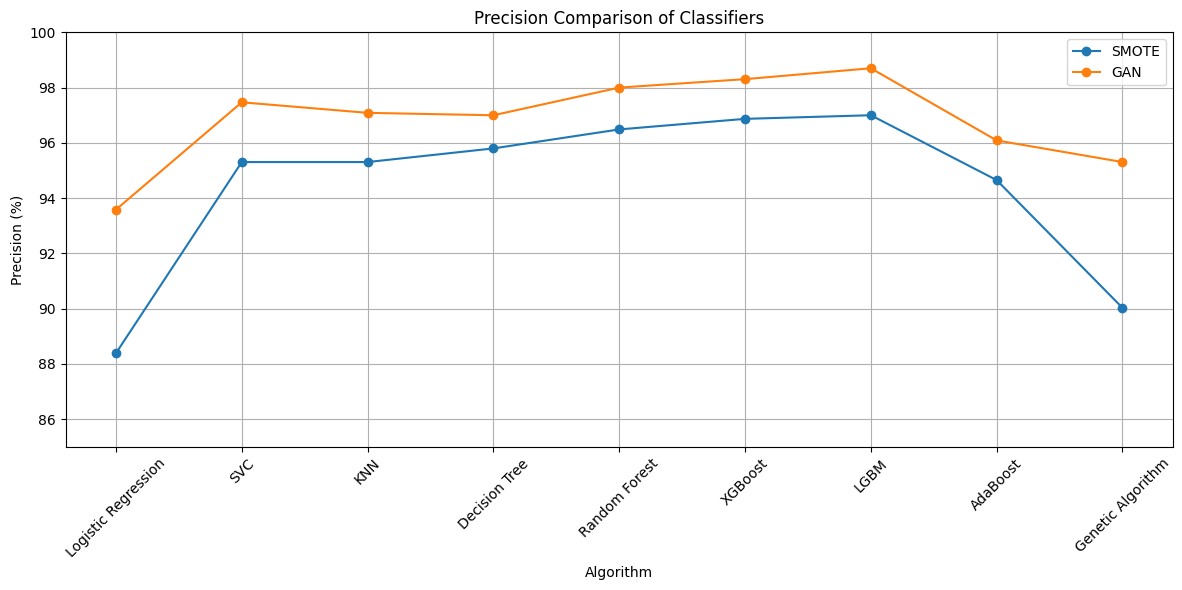

In [75]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(algorithms, smote_precision, marker='o', label='SMOTE')
plt.plot(algorithms, gan_precision, marker='o', label='GAN')

plt.title('Precision Comparison of Classifiers')
plt.xlabel('Algorithm')
plt.ylabel('Precision (%)')
plt.ylim(85, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

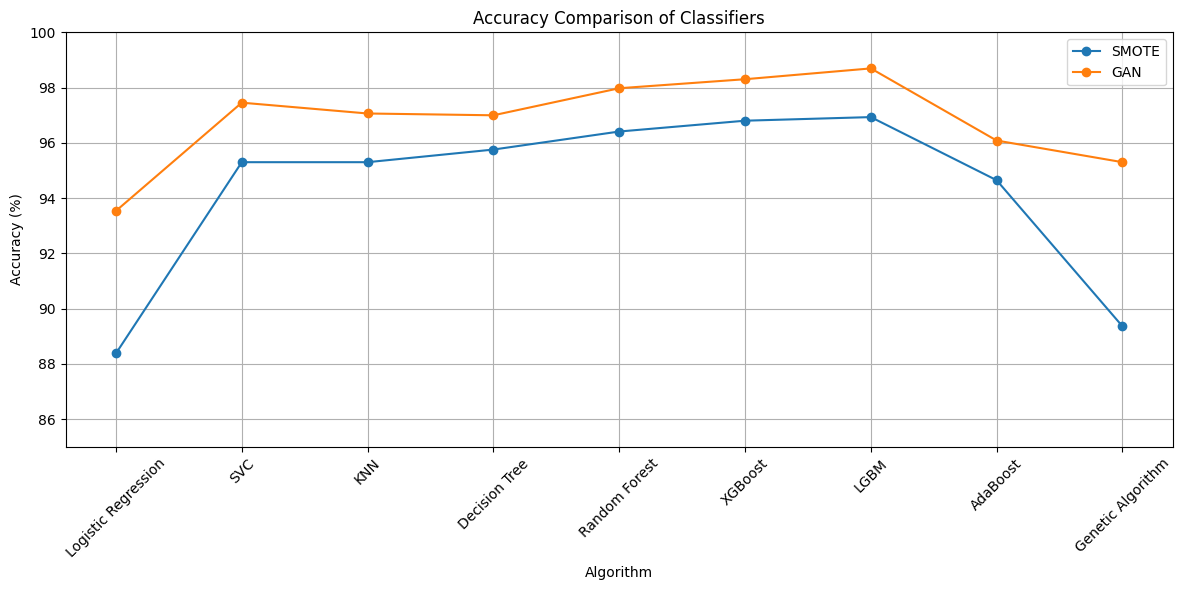

In [76]:
# Plotting the results
plt.figure(figsize=(12, 6))
algorithms = list(classifiers.keys())
plt.plot(algorithms, smote_accuracy, marker='o', label='SMOTE')
plt.plot(algorithms, gan_accuracy, marker='o', label='GAN')

# Adding titles and labels
plt.title('Accuracy Comparison of Classifiers')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy (%)')
plt.ylim(85, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Algorithm': algorithms,
    'SMOTE Recall': smote_recall,
    'GAN Recall': gan_recall,
    'SMOTE F1-score': smote_f1score,
    'GAN F1-score': gan_f1score,
    'SMOTE Precision': smote_precision,
    'GAN Precision': gan_precision,
    'SMOTE Accuracy': smote_accuracy,
    'GAN Accuracy': gan_accuracy
})

# Display the table
print(results_df)

             Algorithm  SMOTE Recall  GAN Recall  SMOTE F1-score  \
0  Logistic Regression     88.381201   93.537859       88.380706   
1                  SVC     95.300261   97.454308       95.300133   
2                  KNN     95.300261   97.062663       95.300133   
3        Decision Tree     95.757180   96.997389       95.756224   
4        Random Forest     96.409922   97.976501       96.408451   
5              XGBoost     96.801567   98.302872       96.800420   
6                 LGBM     96.932115   98.694517       96.931015   
7             AdaBoost     94.647520   96.083551       94.647374   
8    Genetic Algorithm     89.360313   95.300261       89.315696   

   GAN F1-score  SMOTE Precision  GAN Precision  SMOTE Accuracy  GAN Accuracy  
0     93.536138        88.387743      93.584284       88.381201     93.537859  
1     97.454125        95.305203      97.467980       95.300261     97.454308  
2     97.062301        95.305203      97.085855       95.300261     97.062663  

It's clearly visible how GAN augmented dataset outperforms SMOTE balanced dataset in all the models.

The LGBM algorithm exhibited the most pronounced improvement, achieving a recall of 98.7% compared to SMOTE's 96.9% across all metrics.

# Model Testing

LGBM model is choosen out of all the off-the-shelf models and the GA-CS algorithm.

For the final testing, training and validation sets would be combined to form a comulative training set which would be tested on the preserved test set.

GridSearchCV would be used to find the best hyperparameter for the model.

In [79]:
# Combine training and validation sets
X_train_all = np.concatenate((X_train_balanced, X_val_balanced), axis=0)
y_train_all = np.concatenate((y_train_balanced, y_val_balanced), axis=0)

# Initialize and train the LGBM model
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train_all, y_train_all)

# Predict on the test set
y_pred_test = lgbm_model.predict(X_test)

# Evaluate performance on the test set
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


[LightGBM] [Info] Number of positive: 6129, number of negative: 6129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3915
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1533
           1       0.98      0.94      0.96       436

    accuracy                           0.98      1969
   macro avg       0.98      0.97      0.97      1969
weighted avg       0.98      0.98      0.98      1969

[[1524    9]
 [  26  410]]


In [80]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'num_leaves': [31, 63, 127]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=2)

# # Fit the grid search to the combined training and validation data
# grid_search.fit(X_train_all, y_train_all)

In [81]:
# Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 31} to train the lgbm model

# Initialize and train the LGBM model with the best parameters
best_params = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 31}
lgbm_model_best = lgb.LGBMClassifier(**best_params)
lgbm_model_best.fit(X_train_all, y_train_all)

# Predict on the test set
y_pred_test_best = lgbm_model_best.predict(X_test)

# Evaluate performance on the test set
print(classification_report(y_test, y_pred_test_best))
print(confusion_matrix(y_test, y_pred_test_best))


[LightGBM] [Info] Number of positive: 6129, number of negative: 6129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3915
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

# Model Evaluation

## ROC

The ROC curve plots the True Positive Rate (TPR) against the
False Positive Rate (FPR) across various classification thresholds, providing a comprehensive measure of
a model's discriminatory power.



[LightGBM] [Info] Number of positive: 6129, number of negative: 6129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3917
[LightGBM] [Info] Number of data points in the train set: 12258, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


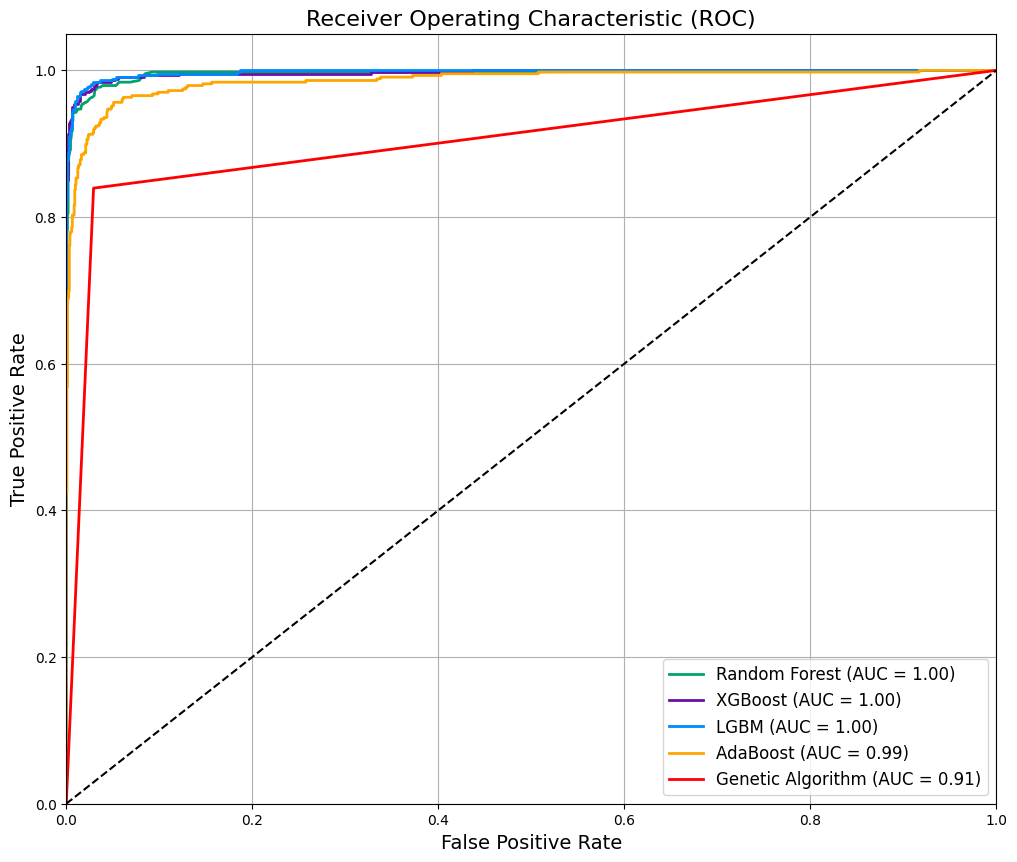

In [ ]:
primary_colors = {
    "LGBM": '#008BFB',                 # Blue
    'Genetic Algorithm': '#FF0000',    # Red
    "Random Forest": '#00A36C',        # Green
    "XGBoost": '#6A0DAD',              # Purple
    "AdaBoost": '#FFA500',             # Yellow
}

# Initialize lists for storing ROC data
fpr_list = []
tpr_list = []
roc_auc_list = []
classifiers_with_roc = []

# Iterate through classifiers
for name, clf in classifiers.items():
    if name not in primary_colors:
        continue

    if name != 'Genetic Algorithm':
        clf.fit(X_train_all, y_train_all)

    # Use predict for Keras Sequential model, predict_proba for others
    if isinstance(clf, Sequential):
        y_pred_proba = clf.predict(X_test)
    else:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Store ROC curve data
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    classifiers_with_roc.append(name)  # Track which classifiers have ROC data

# Plot ROC curves
plt.figure(figsize=(12, 10))

# Plot ROC curves for each classifier in primary_colors
for i, name in enumerate(classifiers_with_roc):
    color = primary_colors.get(name, '#808080')
    plt.plot(fpr_list[i], tpr_list[i], color=color, lw=2, label=f'{name} (AUC = {roc_auc_list[i]:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

## Confusion Matrix (LGBM)

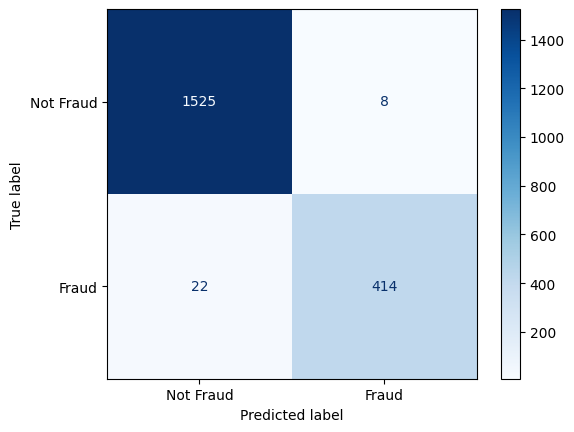

In [85]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_best)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

The high recall, as shown by the 414 true positives and the minimal 10 false positive, demonstrates the model’s robustness in handling large and imbalanced datasets. Additionally, with only 22 false negatives, the LGBM model effectively reduces the risk of overlooking fraudulent activities.

## SHAP Analysis

In [ ]:
# Create a SHAP explainer
explainer = shap.Explainer(lgbm_model_best)
shap_values = explainer(X_test)

### Summary Plot

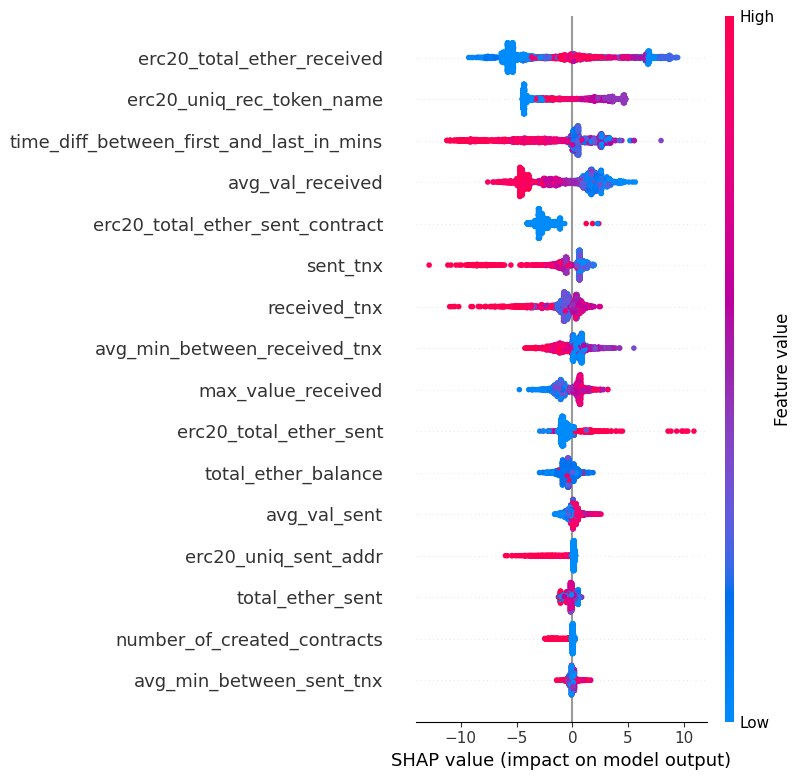

In [ ]:
# Plot the summary plot
shap.summary_plot(shap_values, X_test)

***erc20_total_ether_received*** emerged
as the most significant predictor of fraudulent behaviour.

### Dependency Plot

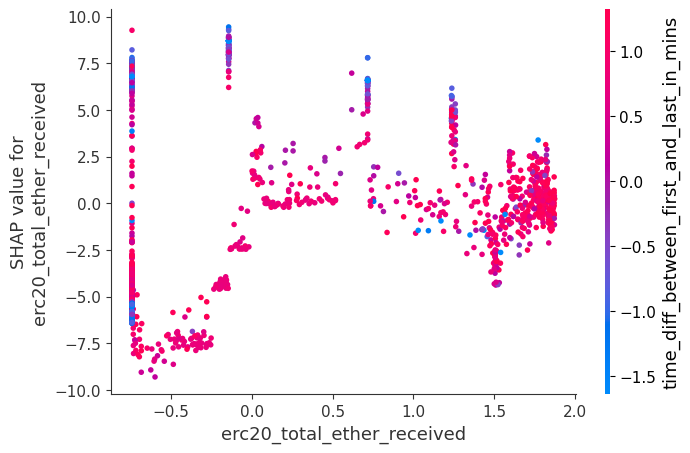

In [ ]:
# Dependency plot
shap.dependence_plot('erc20_total_ether_received', shap_values.values, X_test)

This feature, reveals a non-linear interaction where both extremely high and low ether receipts are associated with significant SHAP values. This dual association suggests a range of suspicious activities, from low volume "dusting" attacks to large-scale
laundering schemes

### Waterfall plot

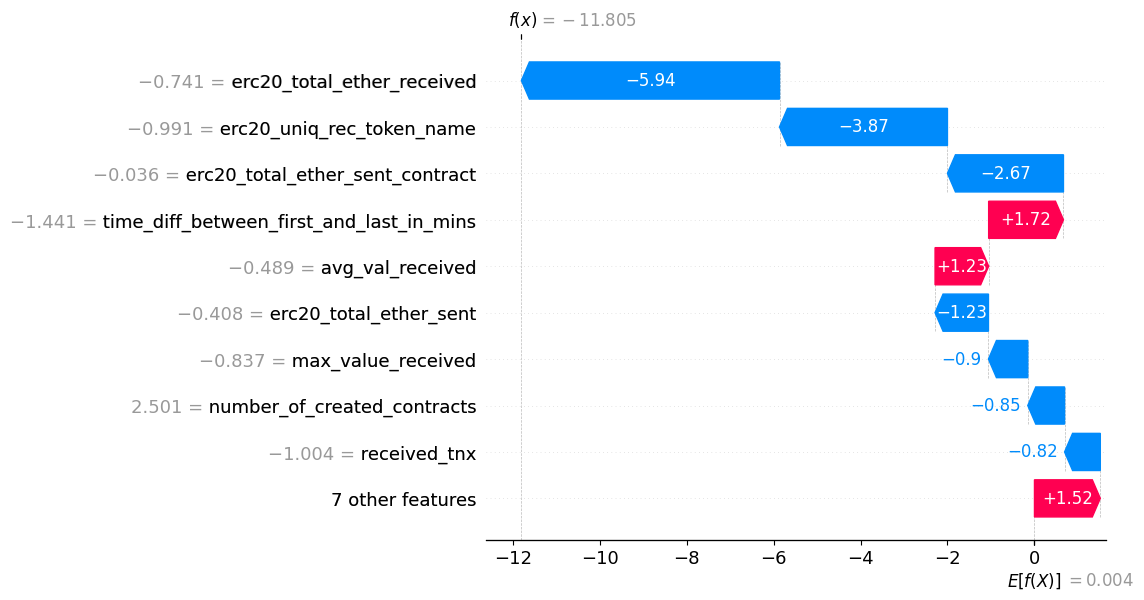

In [ ]:
# Waterfall plot
shap.plots.waterfall(shap_values[0])

***erc20_total_ether_receive*** and
***time_diff_between_first_and_last_in_mins*** displays a critical interaction, further emphasizing the role of transaction timing in uncovering coordinated fraudulent activities.

# Conclusion

This study significantly improved fraudulent transaction detection in the Ethereum blockchain by implementing a novel approach based on GANs.

The LGBM model achieved a remarkable recall rate of 98.56% and precision of 98.57%,
highlighting its superior capacity to detect fraud. This surpasses the current advanced technique, which,
while innovative, did not achieve the same level of precision and recall in this context.